<a href="https://colab.research.google.com/github/snufkin92/colab_tutorial/blob/master/section_08/simple_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シンプルなGRUの実装
GRU層を用いてシンプルなニューラルネットワークを構築し、時系列データを学習します。  
今回は、LSTMとGRUを比較します。

## 訓練用データの作成
訓練用のデータを作成します。  
サイン関数に乱数でノイズを加えたデータを作成し、過去の時系列データから未来の値を予測できるようにします。  
これまでと同様に、正解は入力の時系列を一つ後にずらしたものにします。

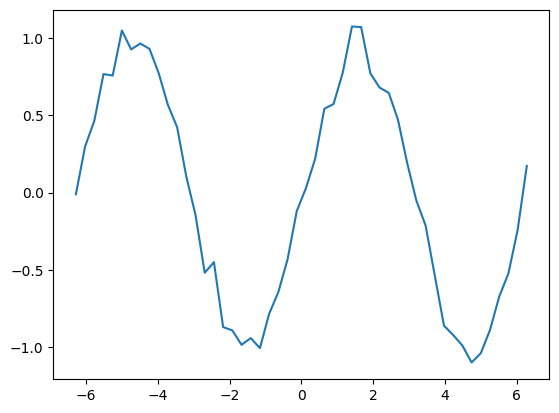

(40, 10, 1)
(40, 10, 1)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

x_data = np.linspace(-2*np.pi, 2*np.pi)  # -2πから2πまで
sin_data = np.sin(x_data) + 0.1*np.random.randn(len(x_data))  # sin関数に乱数でノイズを加える

plt.plot(x_data, sin_data)
plt.show()

n_rnn = 10  # 時系列の数
n_sample = len(x_data)-n_rnn  # サンプル数
x = np.zeros((n_sample, n_rnn))  # 入力
t = np.zeros((n_sample, n_rnn))  # 正解
for i in range(0, n_sample):
    x[i] = sin_data[i:i+n_rnn]
    t[i] = sin_data[i+1:i+n_rnn+1]  # 時系列を入力よりも一つ後にずらす

x = x.reshape(n_sample, n_rnn, 1)  # サンプル数、時系列の数、入力層のニューロン数
print(x.shape)
t = t.reshape(n_sample, n_rnn, 1)  # 今回は入力と同じ形状
print(t.shape)

## LSTMとGRUの比較
Kerasを使ってLSTM、およびGRUを構築します。  
Kerasにおいて、GRU層はSimpleRNN層やLSTM層と同じ方法で追加することができます。

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

batch_size = 8  # バッチサイズ
n_in = 1  # 入力層のニューロン数
n_mid = 20  # 中間層のニューロン数
n_out = 1  # 出力層のニューロン数

# 比較のためのLSTM
model_lstm = Sequential()
model_lstm.add(LSTM(n_mid, input_shape=(n_rnn, n_in), return_sequences=True))
model_lstm.add(Dense(n_out, activation="linear"))
model_lstm.compile(loss="mean_squared_error", optimizer="sgd")
print(model_lstm.summary())

# GRU
model_gru = Sequential()
model_gru.add(GRU(n_mid, input_shape=(n_rnn, n_in), return_sequences=True))
model_gru.add(Dense(n_out, activation="linear"))
model_gru.compile(loss="mean_squared_error", optimizer="sgd")
print(model_gru.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 20)            1760      
                                                                 
 dense (Dense)               (None, 10, 1)             21        
                                                                 
Total params: 1781 (6.96 KB)
Trainable params: 1781 (6.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 20)            1380      
                                                                 
 dense_1 (Dense)             (None, 10, 1)             21        
                                                               

LSTMよりもGRUの方がモデルがシンプルなため、パラメータが少ないことが確認できます。

## 学習
構築したRNNのモデルを使って、学習を行います。  

In [3]:
import time

epochs = 1000

# LSTM
start_time = time.time()
history_lstm = model_lstm.fit(x, t, epochs=epochs, batch_size=batch_size, verbose=0)
print("学習時間 --LSTM--:", time.time() - start_time)

# GRU
start_time = time.time()
history_gru = model_gru.fit(x, t, epochs=epochs, batch_size=batch_size, verbose=0)
print("学習時間 --GRU--:", time.time() - start_time)

学習時間 --LSTM--: 37.637221574783325
学習時間 --GRU--: 25.866968631744385


エポック数が同じ場合、パラメータ数が少ないためGRUの方が学習に時間がかかりません。

## 学習の推移
誤差の推移を確認します。

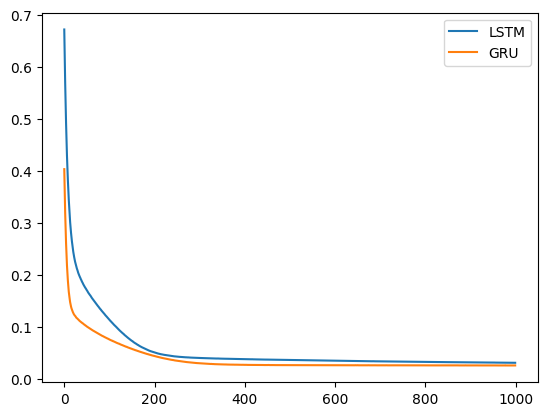

In [4]:
loss_lstm = history_lstm.history['loss']
loss_gru = history_gru.history['loss']

plt.plot(np.arange(len(loss_lstm)), loss_lstm, label="LSTM")
plt.plot(np.arange(len(loss_gru)), loss_gru, label="GRU")
plt.legend()
plt.show()

LSTMと比較して、GRUの方が早く収束します。

## 学習済みモデルの使用
それぞれの学習済みモデルを使って、サイン関数の次の値を予測します。

1/1 [==============================] - 0s 21ms/step


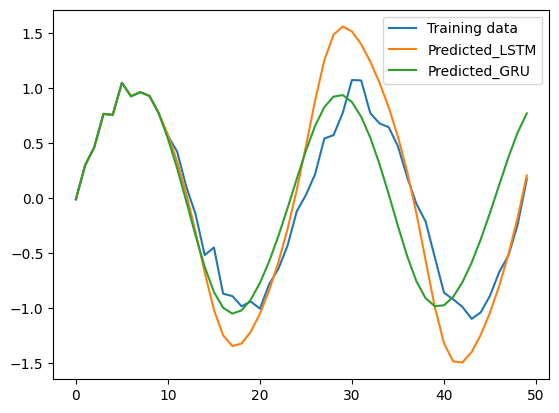

In [5]:
predicted_lstm = x[0].reshape(-1)
predicted_gru = x[0].reshape(-1)

for i in range(0, n_sample):
    y_lstm = model_lstm.predict(predicted_lstm[-n_rnn:].reshape(1, n_rnn, 1))
    predicted_lstm = np.append(predicted_lstm, y_lstm[0][n_rnn-1][0])
    y_gru = model_gru.predict(predicted_gru[-n_rnn:].reshape(1, n_rnn, 1))
    predicted_gru = np.append(predicted_gru, y_gru[0][n_rnn-1][0])

plt.plot(np.arange(len(sin_data)), sin_data, label="Training data")
plt.plot(np.arange(len(predicted_lstm)), predicted_lstm, label="Predicted_LSTM")
plt.plot(np.arange(len(predicted_gru)), predicted_gru, label="Predicted_GRU")
plt.legend()
plt.show()

GRUを使ったモデルも、シンプルなRNNやLSTMと同様にサインカーブを学習できていることが分かります。  
このグラフでは、GRUの方がよく収束しています。

このように、GRUはパラメータ数が少ないため1エポックに必要な時間は短く、LSTMよりも早く収束する傾向があります。  
ただ、LSTMの方が複雑な時系列の学習に向いているケースもあるので、状況に応じてLSTMとGRUを使い分ける必要があります。